In [1]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
 
import geopandas as gpd
import json
import rasterio as rio
from PIL import ImageColor
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [9]:
lc_dir = r"C:\Users\sures\LULCMAPS_new\lc_new_file.json"
raster_dir = r"C:\Users\sures\LULCMAPS_new\img1_Clip.tif"
points_dir = r"C:\Users\sures\LULCMAPS_new\points_FeaturesToJSON30.json"


In [10]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

In [11]:
# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]
 

In [12]:
# Create colormap from values and palette
cmap = ListedColormap(palette)

In [13]:
# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}
 
lc_df
 
s2 = rio.open(raster_dir)
s2_image = s2.read() / 1e4
 
sample = gpd.read_file(points_dir)
sample['lc'] = sample['lc'].astype(str)
sample["value"] = sample["lc"].map(dict_values)
sample["label"] = sample["value"].map(dict_label)

(1051, 6)


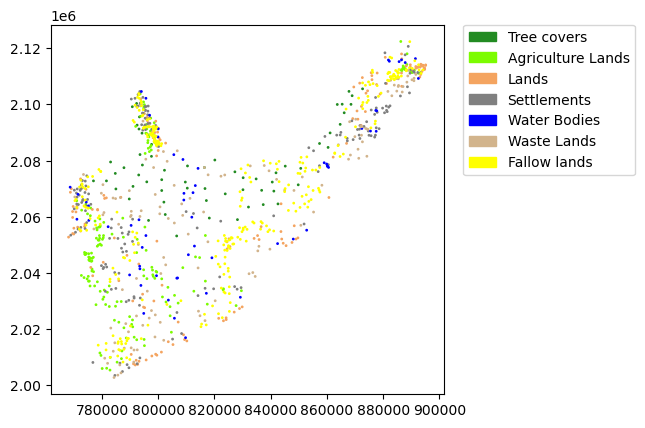

In [14]:
# Plot sample
sample.plot(column="value", cmap=cmap, markersize=1)
plt.legend(**legend)
 
sample_extract = sample.copy()
coords = [
    (x, y) for x, y in zip(sample_extract["geometry"].x, sample_extract["geometry"].y)
]
print(sample_extract.shape)
 
blue = s2_image[0, :, :]  
green = s2_image[1, :, :]  
red = s2_image[2, :, :] 
nir = s2_image[6, :, :] 
ndvi = s2_image[7, :, :]
 
 
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

In [15]:
# Normalize RGB bands
red_norm = normalize_band(red)
green_norm = normalize_band(green)
blue_norm = normalize_band(blue)

In [16]:
# Normalize NIR 
nir_norm = normalize_band(nir)

In [17]:
# Create Natural and False Color Composite Images
rgb = np.dstack((red_norm, green_norm, blue_norm))
fcc = np.dstack((nir_norm, red_norm, green_norm))

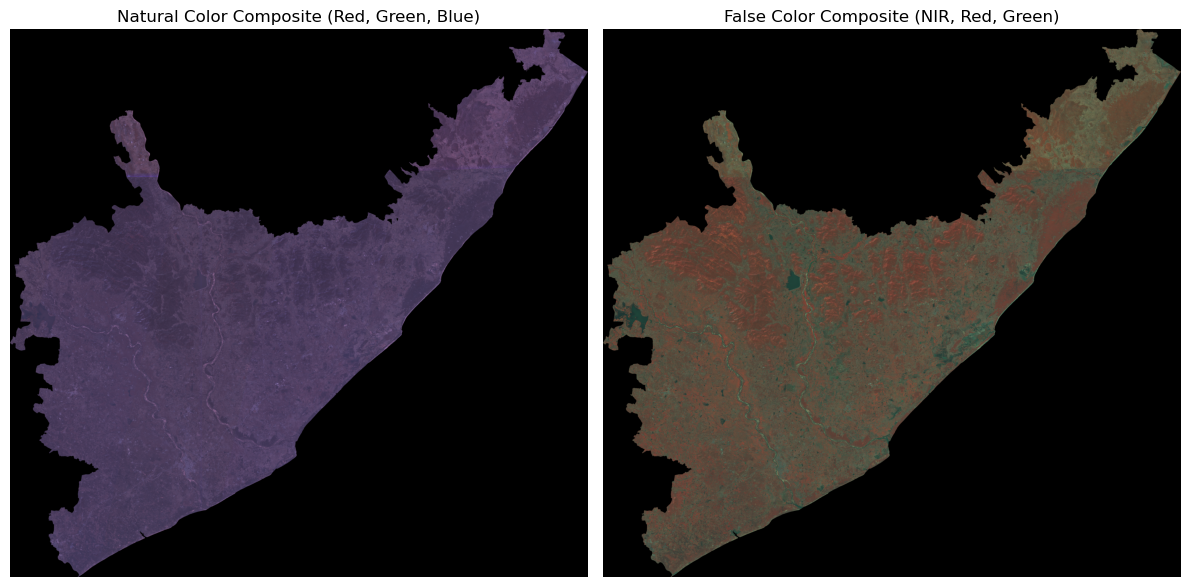

In [19]:
# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
# Natural Color Composite Image
axs[0].imshow(rgb)
axs[0].set_title("Natural Color Composite (Red, Green, Blue)")
axs[0].axis("off")
 
# False Color Composite Image
axs[1].imshow(fcc)
axs[1].set_title("False Color Composite (NIR, Red, Green)")
axs[1].axis("off")
 
plt.tight_layout()
plt.show()

In [20]:
# Normalize NDVI values
ndvi_norm = normalize_band(ndvi)
 

In [21]:
# Define NDVI colormap
ndvi_cmap = plt.cm.YlGn  
ndvi_min, ndvi_max = -0.2, 1 

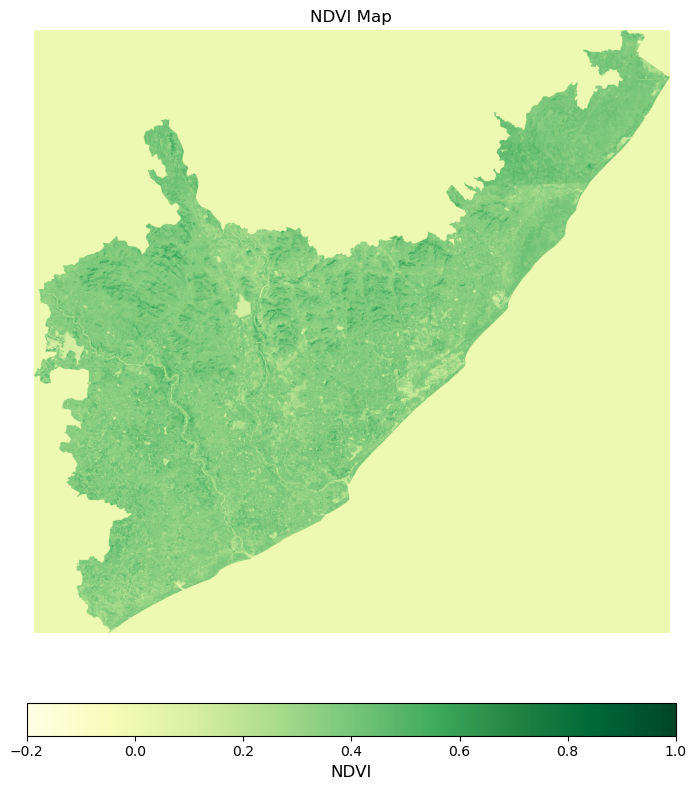

In [25]:
# Create a new figure for NDVI
fig, ax = plt.subplots(figsize=(8, 8))  
 
# NDVI Image
ndvi_plot = ax.imshow(ndvi_norm, cmap=ndvi_cmap, vmin=ndvi_min, vmax=ndvi_max)
ax.set_title("NDVI Map")
ax.axis("off")
# Add a horizontal colorbar for NDVI
cbar = plt.colorbar(ndvi_plot, ax=ax, orientation="horizontal", fraction=0.046, pad=0.1)
cbar.set_label("NDVI", fontsize=12)
 
# Display the plot
plt.tight_layout()
plt.show()

In [26]:
import numpy as np
 
# Extract raster values
all_bands = np.stack([x for x in s2.sample(coords)])

In [27]:
# Reflectance bands (excluding NDVI column)
reflectance_bands = all_bands[:, :-1] / 1e4  # Divide all bands except NDVI by 1e4

In [28]:
# Calculate NDVI using the NIR (B8) and Red (B4) bands
# B8 corresponds to NIR (band 7) and B4 corresponds to Red (band 3) in Sentinel-2
NIR_band = all_bands[:, 6]  
Red_band = all_bands[:, 2]
 

In [29]:
# Compute NDVI
ndvi_band = (NIR_band - Red_band) / (NIR_band + Red_band)

C:\Users\sures\AppData\Local\Temp\ipykernel_18492\4162299931.py:2: RuntimeWarning: invalid value encountered in divide
  ndvi_band = (NIR_band - Red_band) / (NIR_band + Red_band)


In [38]:
# Select the first 7 columns from reflectance_bands
reflectance_bands_selected = reflectance_bands[:, :7]

# Verify the shape
print("Shape of reflectance_bands_selected:", reflectance_bands_selected.shape)

# Assign selected columns to sample_extract
sample_extract[["B2", "B3", "B4", "B5", "B6", "B7", "B8"]] = reflectance_bands_selected


Shape of reflectance_bands_selected: (1051, 7)


In [39]:
# Assign computed NDVI directly to the DataFrame
sample_extract["NDVI"] = ndvi_band

In [40]:
# Display the updated DataFrame
print(sample_extract.head())

   OBJECTID lc        class                        geometry  value  \
0         1  1  Tree covers  POINT (792288.014 2100315.749)    1.0   
1         2  1  Tree covers  POINT (790765.072 2099151.147)    1.0   
2         3  1  Tree covers    POINT (793306.01 2095523.48)    1.0   
3         4  1  Tree covers  POINT (792467.184 2092611.456)    1.0   
4         5  1  Tree covers   POINT (793139.07 2091222.892)    1.0   

         label  NDVI      B2      B3      B4      B5      B6      B7      B8  
0  Tree covers  3336  0.1670  0.1946  0.2261  0.2294  0.2979  0.3723  0.3972  
1  Tree covers  3494  0.1488  0.1611  0.1810  0.2029  0.2393  0.2759  0.3044  
2  Tree covers  3154  0.1395  0.1555  0.1772  0.1898  0.2402  0.2820  0.3109  
3  Tree covers  2984  0.1278  0.1480  0.1706  0.1720  0.2198  0.3035  0.3384  
4  Tree covers  2834  0.1443  0.1669  0.1988  0.1974  0.2580  0.3387  0.3728  


In [41]:
# Extract raster values
all_bands = np.stack([x for x in s2.sample(coords)])
reflectance_bands = all_bands[:, :-1] / 1e4  # Divide all bands except NDVI by 1e4
ndvi_band = all_bands[:, -1]  
 
x = sample_extract[['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'NDVI']]
Y = sample_extract['value']
sample_extract
 
print(x.shape)  # Should be (n_samples, n_features)
print(Y.shape)

(1051, 8)
(1051,)


In [46]:
# Split sample to train and test
seeds = 2
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, train_size=0.7, random_state=seeds, stratify=Y)
print(f'Train size: {len(x_train)}\nTest size: {len(x_test)}')

Train size: 735
Test size: 315


In [47]:
# Define model
rf_model = RandomForestClassifier(random_state=42)

In [48]:
# Train the model
rf_model.fit(x_train, Y_train)
 

RandomForestClassifier(random_state=42)

In [49]:
# Make predictions on the test set
rf_model_pred = rf_model.predict(x_test)

In [50]:
# Evaluate the model
print(classification_report(Y_test, rf_model_pred, zero_division=0))
 

              precision    recall  f1-score   support

         1.0       0.61      0.58      0.59        19
         2.0       0.53      0.56      0.54        54
         3.0       0.35      0.24      0.29        46
         4.0       0.79      0.88      0.83        50
         5.0       0.64      0.39      0.48        18
         6.0       0.29      0.21      0.24        38
         7.0       0.48      0.61      0.54        90

    accuracy                           0.53       315
   macro avg       0.53      0.49      0.50       315
weighted avg       0.51      0.53      0.51       315



In [51]:
# Compute confusion matrix 
cm = confusion_matrix(Y_test, rf_model_pred)
 

In [52]:
# Display the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

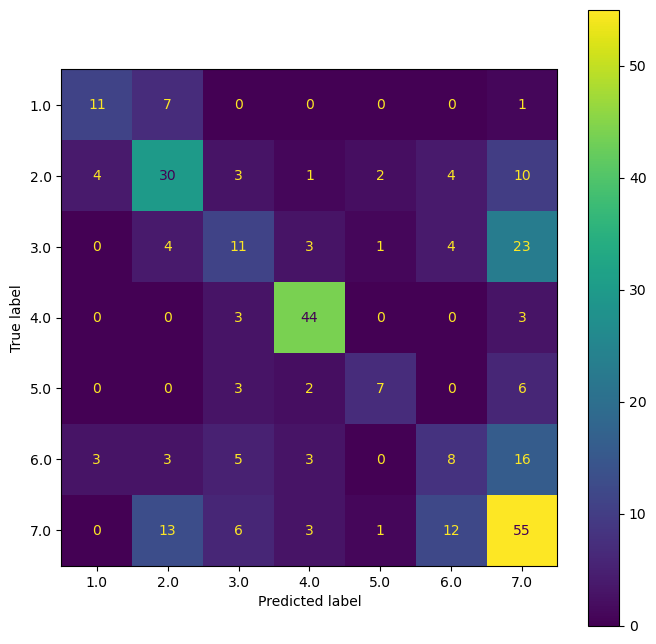

In [53]:
# Customize the plot
fig, ax = plt.subplots(figsize=(8, 8))  
display.plot(
    cmap="viridis",
    values_format="d",  
    ax=ax,
    colorbar=True
)
 

In [54]:
# Remove the grid 
ax.grid(False)
 
# Adjust tick labels for better readability
ax.set_xticks(np.arange(len(rf_model.classes_)))
ax.set_yticks(np.arange(len(rf_model.classes_)))
ax.set_xticklabels(rf_model.classes_, fontsize=8)
ax.set_yticklabels(rf_model.classes_, fontsize=8)
 

[Text(0, 0, '1.0'),
 Text(0, 1, '2.0'),
 Text(0, 2, '3.0'),
 Text(0, 3, '4.0'),
 Text(0, 4, '5.0'),
 Text(0, 5, '6.0'),
 Text(0, 6, '7.0')]

In [55]:
# Adjust text for better readability
for text in ax.texts:
    text.set_size(10) 
    text.set_color("white" if float(text.get_text()) > cm.max() / 2 else "black")  
 

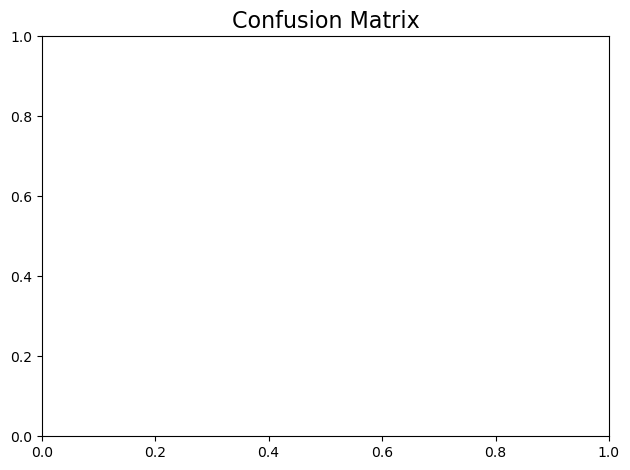

In [59]:
# Add a title
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()
image_transpose = s2_image.transpose(1, 2, 0)  # Shape: (height, width, bands)
transpose_shape = image_transpose.shape

 

In [61]:
reshaped_data = image_transpose.reshape(-1, transpose_shape[2])
print(reshaped_data.shape)  # Verify the number of columns


(39605264, 10)


In [62]:
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B10", "NDVI"]
)


In [63]:
reshaped_data = image_transpose.reshape(-1, transpose_shape[2])[:, :8]
table_image = pd.DataFrame(
    reshaped_data,
    columns=["B2", "B3", "B4", "B5", "B6", "B7", "B8", "NDVI"]
)


In [64]:
print("image_transpose shape:", image_transpose.shape)
print("transpose_shape:", transpose_shape)


image_transpose shape: (6128, 6463, 10)
transpose_shape: (6128, 6463, 10)


In [65]:
# Display the DataFrame
print(table_image)

           B2   B3   B4   B5   B6   B7   B8  NDVI
0         0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
2         0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
3         0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
...       ...  ...  ...  ...  ...  ...  ...   ...
39605259  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
39605260  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
39605261  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
39605262  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
39605263  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0

[39605264 rows x 8 columns]


In [66]:
# Define the feature columns (the ones used during training)
predictors = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "NDVI"]

In [67]:
# Ensure that the feature columns exist in table_image
assert all(col in table_image.columns for col in predictors), "Some feature columns are missing from table_image"
 

In [68]:
# Predict using the trained model
prediction = rf_model.predict(table_image[predictors])
 

In [70]:
# Display the predictions
print(prediction)
prediction_image = prediction.reshape(transpose_shape[0], transpose_shape[1])
 

[3. 3. 3. ... 3. 3. 3.]


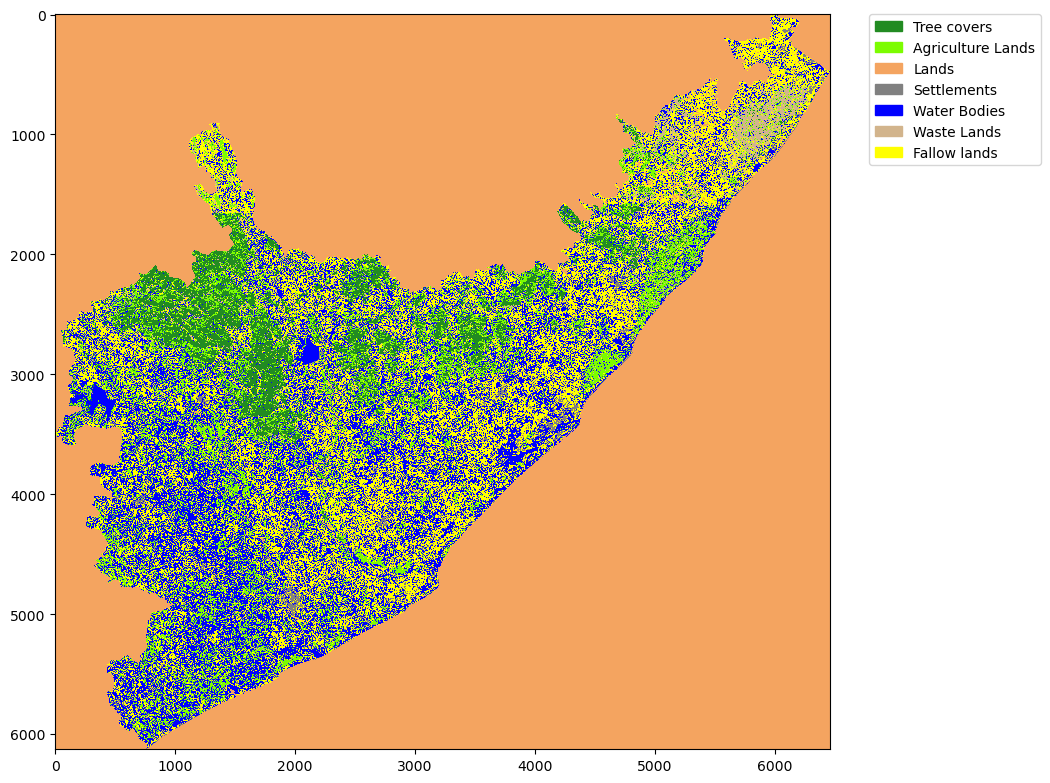

In [71]:
# Show to plot
plt.figure(figsize=(10, 10))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

In [72]:
import rasterio as rio
import os
 

In [73]:
# Define the colormap (example: binary classification)
dict_palette = {0: (0, 0, 0), 1: (255, 255, 255)}  # Black and white palette

In [77]:
# Define the output directory and ensure it exists
output_dir = 'C:/Users/sures/LULCMAPS_new/output'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
 

In [79]:
# Define the output GeoTIFF file path
output_file = os.path.join(output_dir, "LULC_output_new.tif")
try:
    # Open the file for writing
    with rio.open(
        output_file,
        "w",
        driver="COG",  # Cloud Optimized GeoTIFF (COG)
        count=1,
        width=prediction_image.shape[1],
        height=prediction_image.shape[0],
        crs=s2.crs,
        transform=s2.transform,
        dtype="uint8",
        nodata=0,
        tiled=True,
        compress="lzw",  # Optional compression
    ) as output:
        # Apply colormap and write data
        output.write_colormap(1, dict_palette)
        output.write(prediction_image, 1)
 
    print(f"GeoTIFF saved successfully to {output_file}")
 
except Exception as e:
    print(f"Error writing GeoTIFF: {e}") 

GeoTIFF saved successfully to C:/Users/sures/LULCMAPS_new/output\LULC_output_new.tif


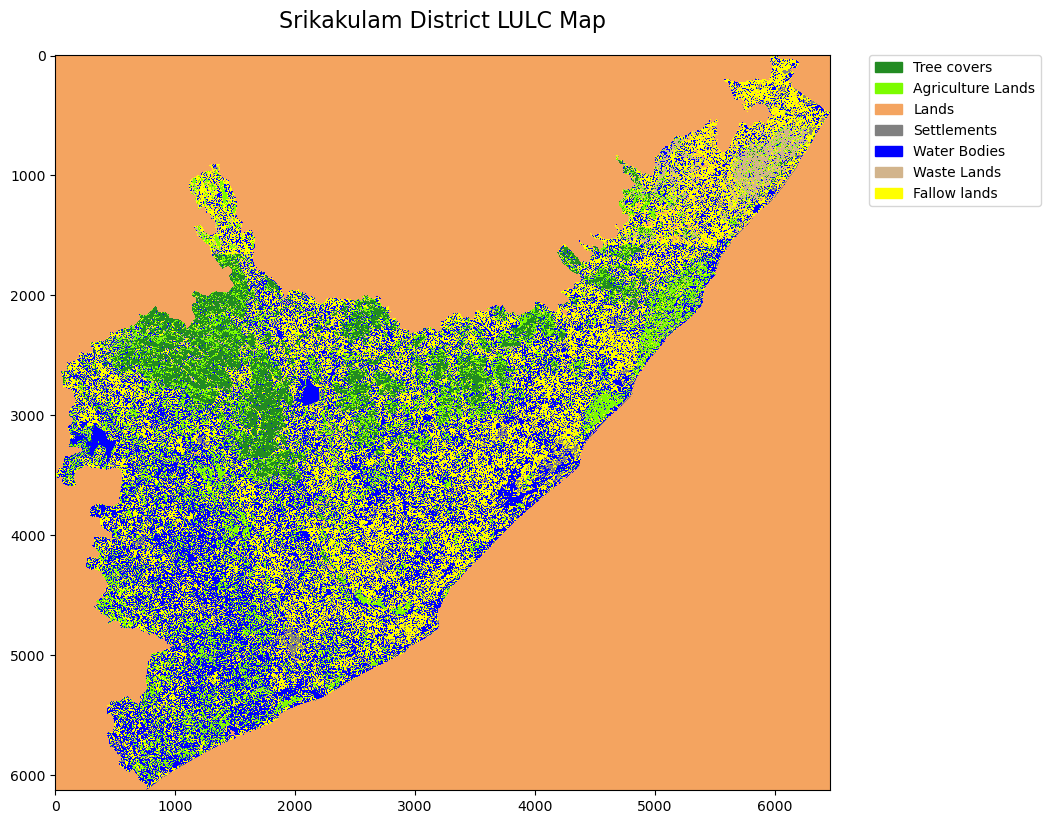

In [81]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")

# Add a title above the image
plt.title('Srikakulam District LULC Map', fontsize=16, pad=20)

# Display the legend (assuming 'legend' is already defined)
plt.legend(**legend)

# Show the plot
plt.show()
